In [ ]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 450kB 53.4MB/s 
     |████████████████████████████████| 3.8MB 56.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d7554ca5797ac8ab71a3993a8a64d8f7bacae2497b6a5209ea1473a1ec733580
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing insta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, add, Activation
from tensorflow.keras.models import Model, Sequential

import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import Callback

#tf.debugging.set_log_device_placement(True)

In [ ]:
'''
Functions for residual modules which have identity and shortcut projections.
And convolutional layers with batch normalization and ReLu activation
'''
def conv2d_bn(x,
              filters,
              strides,
              padding='same'
              ):

    x = tf.keras.layers.Conv2D(filters, (3, 3),
        strides=strides,
        padding=padding, kernel_initializer='he_normal',
        use_bias=False)(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x
    
def conv2d_bn_1x1(x,
              filters,
              strides,
              padding='same'
              ):

    x = tf.keras.layers.Conv2D(filters, (1, 1),
        strides=strides,
        padding=padding, kernel_initializer='he_normal',
        use_bias=False)(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x
    
def conv2d_trans(x,
              filters,
              strides,
              padding='same'
              ):
  
    x = tf.keras.layers.Conv2DTranspose(filters, (3,3), strides=strides, 
                                        padding='same', 
                                        kernel_initializer='he_normal')(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def conv2d_trans_sigmoid(x,
              filters,
              strides,
              padding='same'
              ):
  
    x = tf.keras.layers.Conv2DTranspose(filters, (3,3), strides=strides, 
                                        padding='same', 
                                        kernel_initializer='he_normal')(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    return x
	
	
def residual_module1(layer_in, n_filters):
    # conv1
    x = conv2d_bn(layer_in, n_filters, strides=(1, 1), padding='same')

    # conv2
    conv2 = conv2d_bn(x, n_filters, strides=(1, 1), padding='same')

    # add filters, assumes filters/channels last
    layer_out = add([conv2, layer_in])
    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out


def residual_module2(layer_in, n_filters):
    # conv1
    x = conv2d_bn(layer_in, n_filters, strides=(2, 2), padding='same')
    # conv2
    conv2 = conv2d_bn(x, n_filters, strides=(1, 1), padding='same')
    
    #projection shortcut for mismatch in number of channels
    y = conv2d_bn_1x1(layer_in, n_filters, strides=(2, 2), padding='same')

    # add filters, assumes filters/channels last
    layer_out = add([conv2, y])
    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out

In [ ]:
epochs = 100
latent_dim = 2

def inference_net(x):

  #x = tf.keras.layers.InputLayer(input_shape=(32,32,3))(x)

  x = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))(x)
  x = conv2d_bn(x, filters=32, strides=(2, 2))
  x = conv2d_bn(x, filters=64, strides=(2, 2))
  x = tf.keras.layers.Flatten()(x)

  # No activation outputs
  z_mu = tf.keras.layers.Dense(units = latent_dim)(x)
  z_logvar = tf.keras.layers.Dense(units = latent_dim)(x)

  return z_mu, z_logvar


def generative_net(z):

  x = tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu)(z)
  x = tf.keras.layers.Reshape(target_shape=(7, 7, 32))(x)
  x = conv2d_trans(x, filters=64, strides=(2,2))
  x = conv2d_trans(x, filters=32,strides=(2,2))
  # No activation
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                      strides=1, padding='same')(x)

  return x


In [ ]:
'''
Creating the encoder-decoder model for VAE
'''
def VAE_Model():
  # defining input shape
  x = Input(shape=(28,28,1))

  z_mu, z_log_var = inference_net(x)

  # splitting the output from encoder into two equal dimension tensors of mean 
  # and variance
  #= tf.split(z1, num_or_size_splits=2, axis=1)

  # reparameterization
  eps = K.random_normal(stddev=1.0,shape=(K.shape(x)[0], latent_dim))
  z = eps * tf.exp(z_log_var * .5) + z_mu

  encoder = Model(inputs=x, outputs=[z, z_mu, z_log_var], name='Encoder')
  print(encoder.summary())

  #defining decoder model
  z_s = Input(shape=(latent_dim,), name='z_sampling')
  decoded = generative_net(z_s)
  decoder = Model(inputs = z_s, outputs =decoded, name='decoder')
  print(decoder.summary())

  # decoder invoke
  x_pred = decoder(encoder(x)[2])

  learning_rate = 0.0001
  adm = optimizers.Adam(lr=learning_rate)

  vae = Model(inputs=x, outputs=[x_pred, z_mu, z_log_var], name='VAE')
  #vae.compile(optimizer= adm, loss= vae_loss(z, z_mu, z_log_var, weight),experimental_run_tf_function=False)
  print(vae.summary())

  return vae, encoder, decoder

In [ ]:
'''
Loading data and normalizing it
'''
# write code for training data, validation and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #tf.keras.datasets.cifar10.load_data()

print(type(x_train), x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

def norm_images(images):
  images = np.asarray(images, dtype='f').reshape(images.shape[0], 28, 28, 1) /255.0
  return images

x_train = norm_images(x_train)
x_test = norm_images(x_test)

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(50000).batch(128))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(10000).batch(128))

<class 'numpy.ndarray'> (60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            multiple             0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   288         input_4[1][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 14, 14, 32)   96          conv2d_2[0][0]                   
____________________________________________________________________________________________

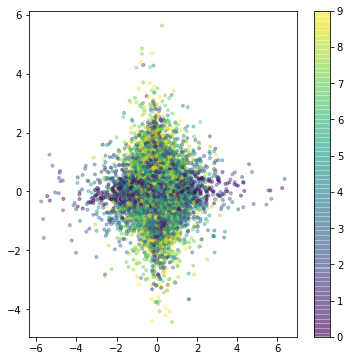

In [ ]:
import time

epochs = 100
# Create the model with the shape of the input
vae, encoder, decoder = VAE_Model()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

# the starting value of weight is 0
# define it as a keras backend variable
weight = tf.Variable(0.)

# The number of epochs at which KL loss should be included
klstart = 19  # 7
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 10  # 10

batch_size = 32
steps_per_epoch = 50000/batch_size

@tf.function
def compute_loss(vae_v, x, wi):
  x_pred, mean, logvar = vae_v(x)

  # reconstruction_loss
  reconstruction_loss = tf.reduce_sum(tf.keras.losses.MSE(x, x_pred), axis=(1,2))
  reconstruction_loss = tf.reduce_mean(reconstruction_loss)

  # kl loss
  kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  #kl_loss *= -0.5

  #reconstruction_loss = tf.reduce_mean(tf.square(x+0.0 - x_pred))
  #print('recon')
  #print(reconstruction_loss)
  
  #kl_l = - 0.5 * K.mean(1 + logvar - K.square(mean) - K.exp(logvar))
  
  return reconstruction_loss + (weight * kl_loss),  reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(vae_model, x, optimizer, w):
  with tf.GradientTape() as tape:
      final_loss, recon_loss, klloss = compute_loss(vae_model, x, w)
  gradients = tape.gradient(final_loss, vae_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae_model.trainable_variables))

  return final_loss, recon_loss, klloss

for epoch in range(1, epochs + 1):
  start_time = time.time()
  print('epoch start ' + str(epoch))
  print(start_time)
  
  if epoch > klstart:
      weight.assign(min(((1. / kl_annealtime)*(epoch-klstart)), 1.))
      print(kl_annealtime)
  print("Current KL Weight is " + str(weight.read_value()))

  step = 0
  for train_x in train_dataset:
      #step = step+1
      #if step == steps_per_epoch:
          #print('step broken at' + str(step))
          #break
      
      if (epoch) == 1:
          global_step = step + 1
      else:
          global_step = (epoch * steps_per_epoch) + (step + 1)
      loss, reloss, kl_loss = compute_apply_gradients(vae, train_x, optimizer, weight)
      x_dash,_,_ = vae(train_x)

      if step % 300 == 0:
          print('in step' + str(step))
          print('loss per 200 batches')
          tf.print(reloss)
          tf.print(kl_loss)
          tf.print(loss)
          #tf.summary.scalar('train_reconstruction_loss', data=reloss, step=global_step)
          #tf.summary.scalar('train_kl_loss', data=kl_loss, step=global_step)
          #tf.summary.scalar('train_loss', data=loss, step=global_step)
          
          #x_dash = x_dash.numpy()
          #x_dash = np.reshape(x_dash, (batch_size, 32, 32, 3))
          #tf.summary.image('reconstructed image slice1', x_dash, max_outputs=batch_size, step=global_step)

          #ip_plt = np.reshape(train_x, (batch_size, 32, 32, 3))
          #tf.summary.image('ip image slice1', ip_plt, max_outputs=batch_size, step=global_step)
          
      step = step+1

  end_time = time.time()

  step = 0
  if epoch % 1 == 0:
      loss = tf.keras.metrics.Mean()
      for test_x in test_dataset:
          #step = step + 1
          #if step == validata_steps:
              #print('step broken at' + str(step))
              #break
          loss(compute_loss(vae, test_x, weight)[0]) 

          if step % 200 == 0:
              print('in validation step' + str(step))
              
          step = step+1

      elbo = loss.result()
      print('Epoch: {}, Test set loss: {}, '
            'time elapse for current epoch {}'.format(epoch,
                                                      elbo,
                                                      end_time - start_time))
      
# display a 2D plot of the digit classes in the latent space
z_test, z_mu_test , z_log_var_test = encoder.predict(x_test, batch_size=batch_size)

from sklearn.decomposition import PCA

X = PCA(n_components=2).fit_transform(z_test)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

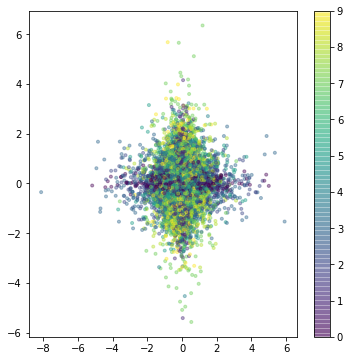

In [ ]:
# display a 2D plot of the digit classes in the latent space
z_test, z_mu_test , z_log_var_test = encoder.predict(x_test, batch_size=batch_size)

from sklearn.decomposition import PCA

#X = PCA(n_components=2).fit_transform(z_test)

plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

(10000, 2)
(2,)
(32, 28, 28, 1)


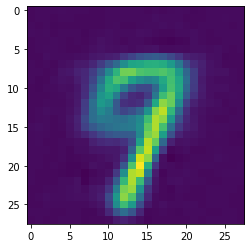

In [ ]:
print(z_test.shape)

print(z_test[0].shape)

x_testhat0 = decoder(z_test[0:32])
print(x_testhat0.shape)

plt.imshow(x_testhat0[12].numpy().reshape(28,28))

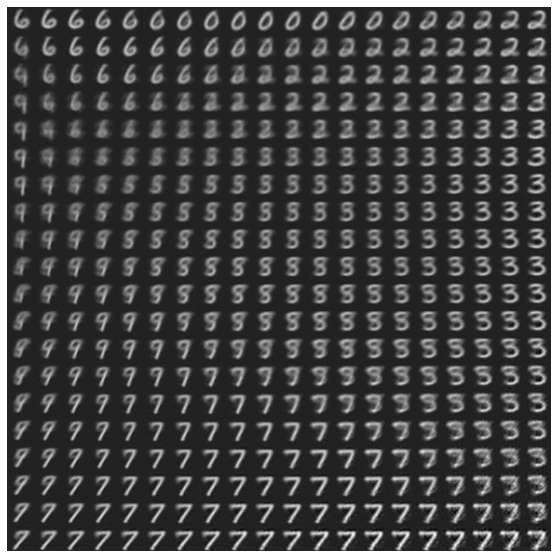

In [ ]:
import tensorflow_probability as tfp

def plot_latent_images(decoder, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = decoder(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

plot_latent_images(decoder, 20)